<a href="https://colab.research.google.com/github/JomarQr/Artificial-Intelligence-path/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
#from google.colab import files
#uploaded = files.upload()

In [4]:
from google.colab import files
uoploaded = files.upload()

Saving perceptron_toydata.txt to perceptron_toydata.txt


In [5]:
path = "perceptron_toydata.txt"

In [6]:
data = np.genfromtxt(path, delimiter = "\t")

**np.genfromtxt(...)** - This function reads data from a text file, especially structured data like CSV or TSV (tab-separated values)

**delimiter="\t"** -  columns in the file are separated by tabs, not commas or spaces. (\t is the tab character.)

In [7]:
x = data[:, :2].astype(np.float32) #input features
y = data[:, 2].astype(np.int64) # class labels

**data[:, :2]** - selects all rows **(:)** and the first two columns **(:2)** → likely your input features.
**.astype(np.float32)** - converts the values to 32-bit floating point numbers (standard format for most ML models).

**y = data[:, 2]** - This selects the third column (index 2) and converts it to 64-bit integers — perfect for classification labels (like 0s and 1s).

In [8]:
np.random.seed(123)

So this line is just making sure everything that follows (like random splits or weight initializations) is predictable.

In [9]:
idx = np.arange(y.shape[0])
np.random.shuffle(idx)

**np.arange(...)** creates an array of indices from 0 to N-1.
**y.shape[0]** gives you the number of data points (number of rows).

**np.random.shuffle(idx)** - This shuffles the index array in place.

In [10]:
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]

**X_test and y_test:**
The first 25 samples — used to evaluate how well your model performs on unseen data.
**X_train and y_train:**
The remaining samples — used to train the model.

In [11]:
#feature normalization (standardization)
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

**np.mean(X_train, axis=0)** -  computes the mean of each feature (column) across all training samples.
**np.std(X_train, axis=0)** - computes the standard deviation of each feature.

This gives you two vectors: one for the mean (mu) and one for the std dev (std) — one value per feature.

**X_train, X_test = (X_train - mu) / std, (X_test - mu) / std** - This standardizes each feature so that:
Mean becomes 0, Standard deviation becomes 1

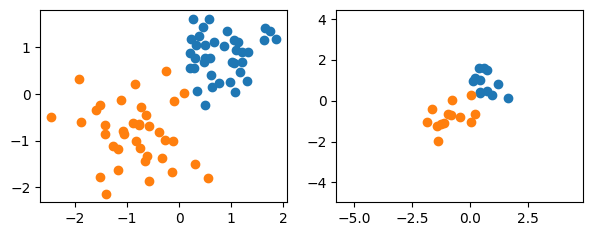

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1,1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0,1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1,1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0,1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

Left subplot = training data

Right subplot = test data

The two colors represent two classes (e.g., 0 and 1)

 The two classes are well-separated, which is great for classification

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define a model



In [14]:
def sigmoid(z):
  return 1. / (1. + torch.exp(-z)) #1. because we would like that the result would be aplicable for vectors

In [16]:
class LogisticRegression():
  def __init__(self, num_features):
    self.num_features = num_features
    self.weights = torch.zeros(1, num_features, dtype=torch.float32, device=device)
    self.bias =torch.zeros(1, dtype=torch.float32, device=device)

  def forward(self, x):
    linear = torch.add(torch.mm(x, self.weights.t()), self.bias).view(-1)
    probabilities = sigmoid(linear)
    return probabilities

  def backward(self, x, y, probabilities):
    grad_loss_wrt_z = probabilities.view(-1) - y
    grad_loss_wrt_w = torch.mm(x.t(), grad_loss_wrt_z.view(-1,1)).t()
    grad_loss_wrt_b = torch.sum(grad_loss_wrt_z)
    return grad_loss_wrt_w, grad_loss_wrt_b

  def predict_labels(self, x):
    probabilities = self.forward(x)
    labels = torch.where(probabilities >=0.5, 1, 0)
    return labels

  def evaluate(self, x, y):
    labels = self.predict_labels(x).float()
    accuracy = torch.sum(labels.view(-1) == y.float()).item()/y.size(0)
    return accuracy

  def _logit_cost(self, y, probability):
    term1 = torch.mm(-y.view(1, -1), torch.log(probability.view(-1, 1)))
    term2 = - torch.mm((1 - y).view(1, -1), torch.log(1 - probability.view(-1, 1)))
    return term1 + term2

  def train(self, x, y, num_epochs, learning_rate=0.01):
    epoch_cost=[]
    for e in range(num_epochs):
      #Compute outputs
      probabilities = self.forward(x)

      #Compute gradients
      grad_w, grad_b =self.backward(x, y, probabilities)

      #Update weights
      self.weights -= learning_rate* grad_w
      self.bias -= learning_rate*grad_b

      #Log the results
      cost = self._logit_cost(y, probabilities)/x.size(0)
      print('Epoch: %03d'%(e+1), end="")
      print('| Train ACC: %.3f' % self.evaluate(x,y), end="")
      print('| Cost: %.3f' % cost)
      epoch_cost.append(cost)
    return epoch_cost


Training the model

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

In [18]:
model = LogisticRegression(num_features=2)
epoch_cost = model.train(X_train_tensor, y_train_tensor, num_epochs=40, learning_rate=0.1)

Epoch: 001| Train ACC: 0.973| Cost: 0.693
Epoch: 002| Train ACC: 0.973| Cost: 0.055
Epoch: 003| Train ACC: 0.973| Cost: 0.053
Epoch: 004| Train ACC: 0.973| Cost: 0.051
Epoch: 005| Train ACC: 0.973| Cost: 0.049
Epoch: 006| Train ACC: 0.973| Cost: 0.048
Epoch: 007| Train ACC: 0.973| Cost: 0.047
Epoch: 008| Train ACC: 0.973| Cost: 0.046
Epoch: 009| Train ACC: 0.973| Cost: 0.045
Epoch: 010| Train ACC: 0.987| Cost: 0.044
Epoch: 011| Train ACC: 0.987| Cost: 0.043
Epoch: 012| Train ACC: 0.987| Cost: 0.042
Epoch: 013| Train ACC: 0.987| Cost: 0.041
Epoch: 014| Train ACC: 0.987| Cost: 0.041
Epoch: 015| Train ACC: 0.987| Cost: 0.040
Epoch: 016| Train ACC: 0.987| Cost: 0.039
Epoch: 017| Train ACC: 1.000| Cost: 0.039
Epoch: 018| Train ACC: 1.000| Cost: 0.038
Epoch: 019| Train ACC: 1.000| Cost: 0.038
Epoch: 020| Train ACC: 1.000| Cost: 0.037
Epoch: 021| Train ACC: 1.000| Cost: 0.036
Epoch: 022| Train ACC: 1.000| Cost: 0.036
Epoch: 023| Train ACC: 1.000| Cost: 0.036
Epoch: 024| Train ACC: 1.000| Cost

In [19]:
epoch_cost2 = [cost.item() for cost in epoch_cost]

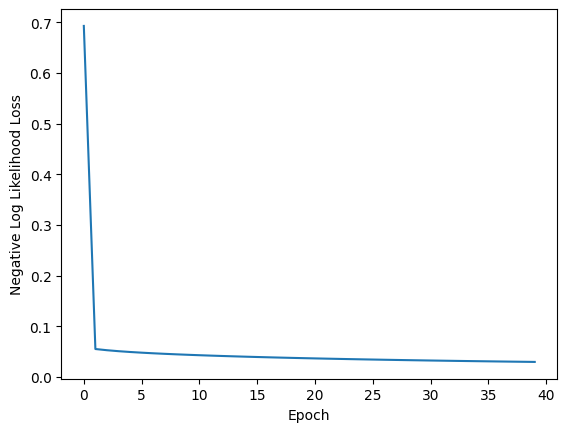

In [20]:
plt.plot(epoch_cost2)
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

In [21]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [22]:
test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

In [23]:
test_accuracy

0.96